# Uncertainty Quantification Analysis


In [1]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.metrics import roc_curve
plt.style.use('utils\plotstyle.mplstyle')

from scipy.special import xlogy

from scipy.stats import ks_2samp, kstest, mannwhitneyu


In [22]:
folder = 'UNIFESP+iCOPE'
model = 'ViTNB'
path_experiments = f'experiments\\{folder}\\{model}'

if model == "VGGNB":
    filename = 'results_MCDP_0.5_30.pkl'
else:
    filename = 'results_MCDP_0.1_30.pkl'

with open(os.path.join(path_experiments, filename), 'rb') as f:
    results = pickle.load(f)

In [3]:
def IQR(dataframe, mode):
    q75, q50, q25 = np.quantile(dataframe[mode], [0.75, 0.50, 0.25])
    iqr = q75 - q25

    upper_fence = q75 + (1.5 *iqr)
    lower_fence = q25 - (1.5 *iqr)

    print(f"Upper Fence: {upper_fence:.4f}")
    print(f"Q75:         {q75:.4f}")
    print(f"Q50:         {q50:.4f}")
    print(f"Q25:         {q25:.4f}")
    print(f"Lower Fence: {lower_fence:.4f}")

    return upper_fence, q75, q50, q25, lower_fence

In [4]:
def youden_index_uncertainty(dataframe, mode='stds'):
    
    preds = dataframe['preds']
    labels = dataframe['labels']
    stds = dataframe[mode]

    incorrects = preds != labels
    fpr_stds, tpr_stds, thresholds_stds = roc_curve(incorrects, stds)

    idx_stds = np.argmax(tpr_stds - fpr_stds)
 
    return thresholds_stds[idx_stds]

In [5]:
def plot_high_uq_images(high_uq, path=f"imgs_uncertain_{model}.pdf"):

    high_uq['subjects'] = high_uq['img_names'].apply(lambda x: x.split('\\')[4].split('_')[2])
    high_uq = high_uq.sort_values(by='subjects')
    
    num_images = len(high_uq)
    #num_rows = int(np.sqrt(num_images))
    #num_cols = int(np.ceil(num_images / num_rows))

    num_rows = 2
    num_cols = 5

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize = (num_cols * 4, num_rows * 4))

    for i in range(num_images):

        sample = high_uq.iloc[i]

        img = cv2.resize(cv2.cvtColor(cv2.imread(sample['img_names']), cv2.COLOR_BGR2RGB), (128,128))

        row = i // num_cols
        col = i % num_cols
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

        if sample['labels'] == sample['preds']:
            color='green'
        else:
            color='red'

        dataset = sample['img_names'].split('\\')[4].split('_')[1]
        label = "Com Dor" if sample['labels'] == 1 else "Sem Dor"
        axes[row, col].set_title((f"{dataset} - {label}"), fontsize=20)
        axes[row, col].text(3,120, f"{sample['probs']:.4f}±{sample['stds']:.2f}", fontsize=20, bbox=dict(facecolor='white', alpha=0.8, edgecolor=color, linewidth=3))

    plt.savefig(path, dpi=300, bbox_inches='tight')

In [23]:
mode = 'stds'

## Verifying predictions uncertainty

In [24]:
corrects = []
stds = []
probs_array = []
img_names = []
labels_array = []
preds_array = []
entropies = []
folds = []
dataset = []

In [26]:
for i, fold in enumerate(results.keys()):
    preds = results[fold]['preds']
    labels = results[fold]['labels']
    probs = results[fold]['probs_uq']
    std = probs.std(axis=1)
    #entropyy = -(results[fold]['probs_uq'] * np.log(results[fold]['probs_uq'] + 1e-10)).sum(axis=1)
    eps = np.finfo(results[fold]['probs_uq'].mean(axis=1).dtype).eps
    probs = np.clip(results[fold]['probs_uq'].mean(axis=1), eps, 1 - eps)
    entropyy = -(xlogy(np.ones(len(results[fold]['probs_uq'])), results[fold]['probs_uq'].mean(axis=1)) + xlogy(1 - np.ones(len(results[fold]['probs_uq'])), 1 - results[fold]['probs_uq'].mean(axis=1)))

    dataset.extend(x.split('\\')[4].split('_')[1] for x in results[fold]['img_names'])

    img_names.extend(results[fold]['img_names'])
    labels_array.extend(labels)
    preds_array.extend(preds)

    stds.extend(std)
    probs_array.extend(results[fold]['probs'])
    corrects.extend((labels == preds))

    entropies.extend(entropyy)

    folds.extend([i] * len(preds))

In [27]:
dataframe = pd.DataFrame({'fold': folds, 'img_names': img_names, 'dataset':dataset, 'labels':labels_array, 'preds': preds_array, 'stds':stds, 'corrects':corrects, 'probs':probs_array, 'entropy':entropies})

In [28]:
dataframe

,fold,img_names,dataset,labels,preds,stds,corrects,probs,entropy
0,0,Datasets\Folds\0\Test\ID1014_UNIFESP_S92_nopai...,UNIFESP,0.0,0.0,0.148555,True,0.147277,1.915442
1,0,Datasets\Folds\0\Test\ID1015_UNIFESP_S92_nopai...,UNIFESP,0.0,0.0,0.142118,True,0.115190,2.161170
2,0,Datasets\Folds\0\Test\ID1016_UNIFESP_S92_nopai...,UNIFESP,0.0,0.0,0.187027,True,0.134713,2.004612
3,0,Datasets\Folds\0\Test\ID1017_UNIFESP_S92_nopai...,UNIFESP,0.0,0.0,0.041162,True,0.016924,4.079011
4,0,Datasets\Folds\0\Test\ID1018_UNIFESP_S92_nopai...,UNIFESP,0.0,0.0,0.048739,True,0.044357,3.115480
...,...,...,...,...,...,...,...,...,...
1037,9,Datasets\Folds\9\Test\ID973_UNIFESP_S88_nopain...,UNIFESP,0.0,0.0,0.250296,True,0.492649,0.707958
1038,9,Datasets\Folds\9\Test\ID974_UNIFESP_S88_nopain...,UNIFESP,0.0,0.0,0.248280,True,0.404276,0.905658
1039,9,Datasets\Folds\9\Test\ID975_UNIFESP_S88_pain.jpg,UNIFESP,1.0,1.0,0.292907,True,0.517829,0.658110
1040,9,Datasets\Folds\9\Test\ID976_UNIFESP_S88_pain.jpg,UNIFESP,1.0,1.0,0.229021,True,0.599399,0.511828


### Uncertainty density distribution for predictions

c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Uncertainty [$\\sigma$]')

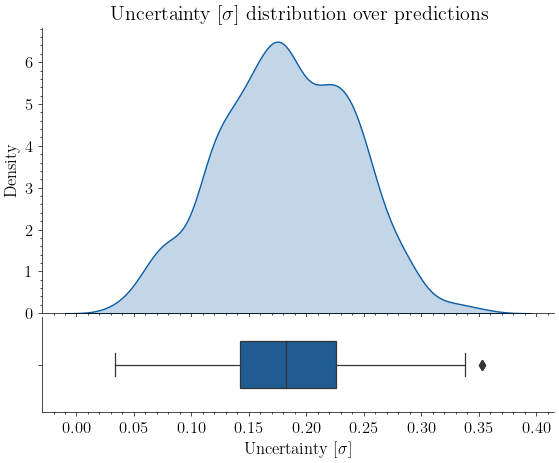

In [29]:
fig = plt.figure()
gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.02)

ax_kde = fig.add_subplot(gs[0])
ax_boxplot = fig.add_subplot(gs[1], sharex=ax_kde)

sns.kdeplot(data=dataframe, x='stds', fill=True, ax=ax_kde)
sns.boxplot(data=dataframe, x='stds', width=0.5, ax=ax_boxplot, linewidth=0.9)

ax_kde.set_title('Uncertainty [$\sigma$] distribution over predictions')
ax_kde.set_ylabel('Density')

ax_boxplot.set_xlabel('Uncertainty [$\sigma$]')

In [33]:
upper_fence, q75, q50, q25, lower_fence = IQR(dataframe, mode=mode)

Upper Fence: 0.3503
Q75:         0.2254
Q50:         0.1819
Q25:         0.1421
Lower Fence: 0.0172


### High uncertain images

In [34]:
high_uq = dataframe[(dataframe[mode]>q75)].sort_values([mode],ascending=False) # Outliers

high_uq_pain = high_uq[high_uq['labels']==1][:10]
high_uq_nopain = high_uq[high_uq['labels']==0][:10]

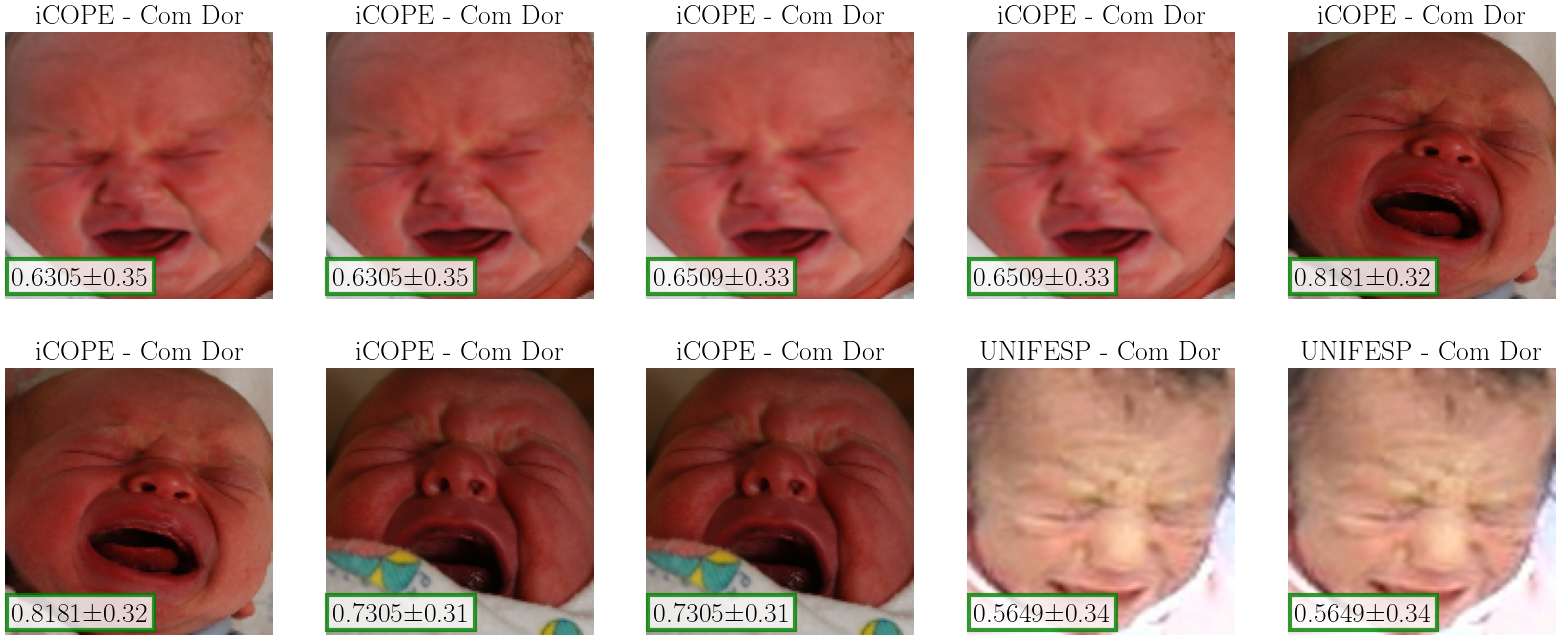

In [35]:
plot_high_uq_images(high_uq_pain, path=f"pain_imgs_uncertain_{model}.pdf")

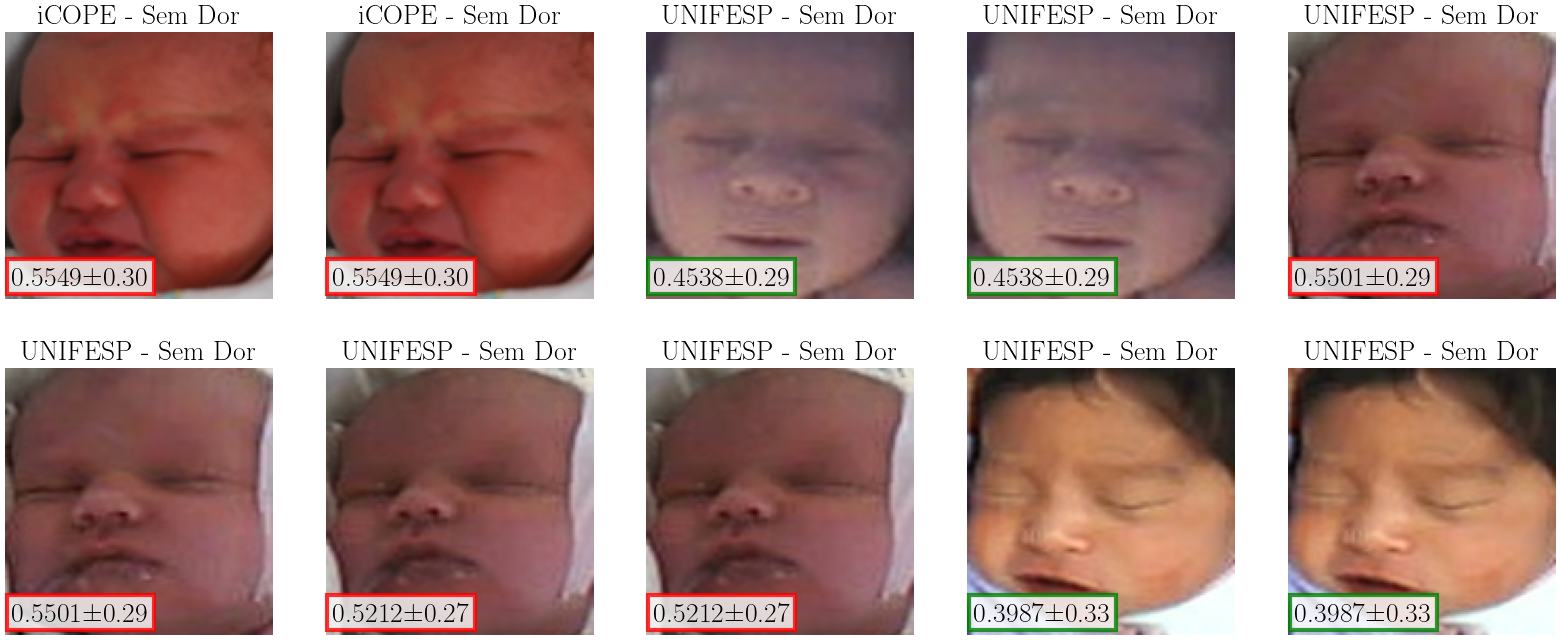

In [36]:
plot_high_uq_images(high_uq_nopain, path=f"nopain_imgs_uncertain_{model}.pdf")

## Verifying the uncertainty in correct and incorrect predictions

c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


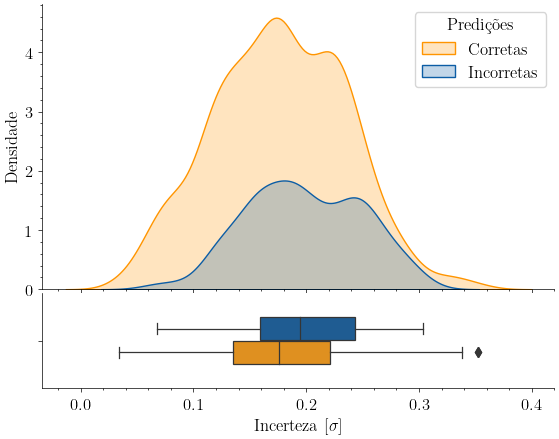

In [37]:
fig = plt.figure()
gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.02)

ax_kde = fig.add_subplot(gs[0])
ax_boxplot = fig.add_subplot(gs[1], sharex=ax_kde)

sns.kdeplot(data=dataframe, x='stds', hue='corrects', fill=True, ax=ax_kde)
sns.boxplot(data=dataframe, x='stds', y=[""] * len(dataframe), hue='corrects', width=0.5, ax=ax_boxplot, linewidth=0.9)

#ax_kde.set_title('Distribuição da incerteza [$\sigma$] distribution over predictions')
ax_kde.set_ylabel('Densidade')
ax_kde.legend(title="Predições", labels=["Corretas","Incorretas"])
ax_kde.tick_params(axis='x', labelbottom=False)

ax_boxplot.set_xlabel('Incerteza [$\sigma$]')
ax_boxplot.get_legend().remove()
plt.savefig(f'MCDP_uncertainty_corrects_{model}.pdf', 
                    dpi=300, 
                    bbox_inches='tight')

In [38]:
stat, p_value = mannwhitneyu(dataframe[dataframe['corrects']==True]['stds'], dataframe[dataframe['corrects']==False]['stds'])
print(p_value)

9.01348199344384e-08


## Verifying uncertainty in Pain and No-pain classes

c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\

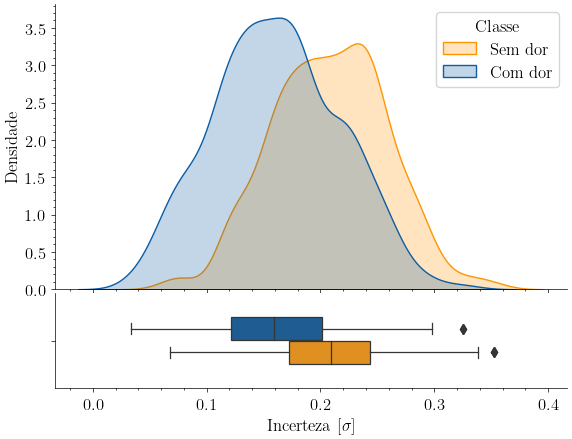

In [39]:
fig = plt.figure()
gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.02)

ax_kde = fig.add_subplot(gs[0])
ax_boxplot = fig.add_subplot(gs[1], sharex=ax_kde)

sns.kdeplot(data=dataframe, x='stds', hue='labels', fill=True, ax=ax_kde)
sns.boxplot(data=dataframe, x='stds', y=[""] * len(dataframe), hue='labels', width=0.5, ax=ax_boxplot, linewidth=0.9)

#ax_kde.set_title('Distribuição da incerteza [$\sigma$] distribution over predictions')
ax_kde.set_ylabel('Densidade')
ax_kde.legend(title="Classe", labels=["Sem dor","Com dor"])
ax_kde.tick_params(axis='x', labelbottom=False)

ax_boxplot.set_xlabel('Incerteza [$\sigma$]')
ax_boxplot.get_legend().remove()
plt.savefig(f'MCDP_uncertainty_class_{model}.pdf', 
                    dpi=300, 
                    bbox_inches='tight')

In [15]:
stat, p_value = ks_2samp(dataframe[dataframe['labels']==0]['stds'], dataframe[dataframe['labels']==1]['stds'])
print(p_value)

0.26968356128697424


## Dataset Uncertainty

c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\

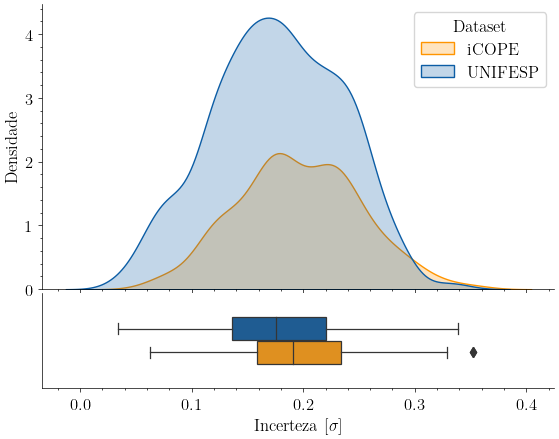

In [40]:
fig = plt.figure()
gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.02)

ax_kde = fig.add_subplot(gs[0])
ax_boxplot = fig.add_subplot(gs[1], sharex=ax_kde)

sns.kdeplot(data=dataframe, x='stds', hue='dataset', fill=True, ax=ax_kde)
sns.boxplot(data=dataframe, x='stds', y=[""] * len(dataframe), hue='dataset', width=0.5, ax=ax_boxplot, linewidth=0.9)

#ax_kde.set_title('Distribuição da incerteza [$\sigma$] distribution over predictions')
ax_kde.set_ylabel('Densidade')
ax_kde.legend(title="Dataset", labels=["iCOPE",'UNIFESP'])
ax_kde.tick_params(axis='x', labelbottom=False)

ax_boxplot.set_xlabel('Incerteza [$\sigma$]')
ax_boxplot.get_legend().remove()
ax_boxplot.set(yticks=[])

plt.savefig(f'MCDP_uncertainty_dataset_{model}.pdf', 
                    dpi=300, 
                    bbox_inches='tight')

In [55]:
stat, p_value = mannwhitneyu(dataframe[dataframe['dataset']=='UNIFESP']['stds'], dataframe[dataframe['dataset']=='iCOPE']['stds'])
print(p_value)

0.0009120191176614891


## Uncertainty by Probs

In [41]:
corrects = dataframe[dataframe['corrects']==True]
incorrects = dataframe[dataframe['corrects']==False]

c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: F

Text(0, 0.5, 'Incerteza [$\\sigma$]')

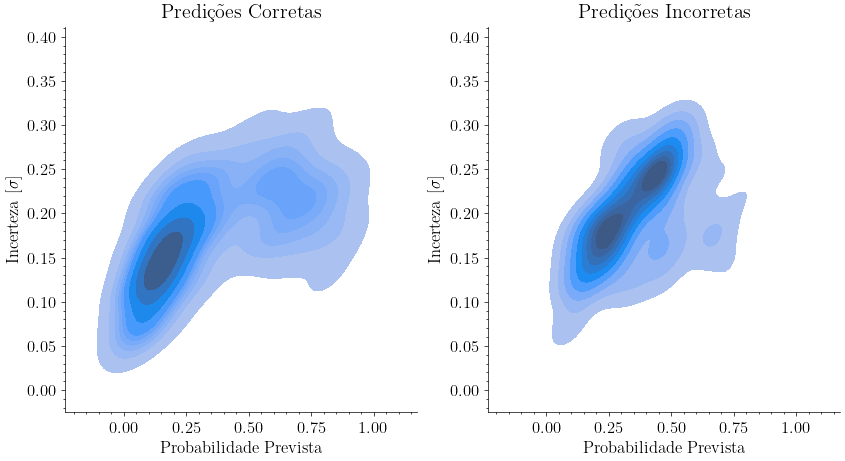

In [42]:
plt.figure(figsize=(10,5))

ax1 = plt.subplot(121)
sns.kdeplot(x=corrects['probs'], y=corrects['stds'], fill=True)
##plt.scatter(corrects['probs'], corrects['stds'], alpha=0.3, color='k')
plt.title('Predições Corretas')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Incerteza [$\sigma$]')


ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
sns.kdeplot(x=incorrects['probs'], y=incorrects['stds'], fill=True)
#plt.scatter(incorrects['probs'], incorrects['stds'])
plt.title('Predições Incorretas')
plt.xlabel('Probabilidade Prevista')
plt.ylabel('Incerteza [$\sigma$]')


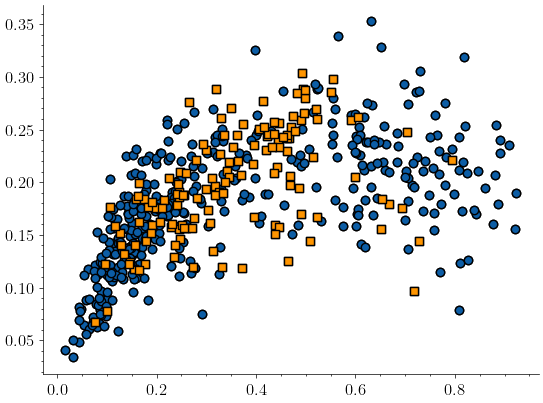

In [43]:
plt.scatter(dataframe[dataframe['corrects']==True]['probs'], dataframe[dataframe['corrects']==True]['stds'], marker='o', edgecolor='k')
plt.scatter(dataframe[dataframe['corrects']==False]['probs'], dataframe[dataframe['corrects']==False]['stds'], marker='s', edgecolor='k')

# MCDP study of p and reps

In [2]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
plt.style.use('utils\plotstyle.mplstyle')

In [6]:
folder = 'UNIFESP+iCOPE'
model = 'VGGNB'
path_experiments = f'experiments\\{folder}\\{model}'

drop_p = ['0.5']
iterations = ['30', '50', '100']

corrects = []
stds = []
probs_array = []
img_names = []
labels_array = []
preds_array = []
p = []
reps = []
entropies = []

for y in iterations:
    for x in drop_p:
        filename = f'results_MCDP_{x}_{y}.pkl'

        with open(os.path.join(path_experiments, filename), 'rb') as f:
            results = pickle.load(f)

        for i, fold in enumerate(results.keys()):
            preds = results[fold]['preds']
            labels = results[fold]['labels']
            probs = results[fold]['probs_uq']
            std = probs.std(axis=1)
            entropyy = -(xlogy(np.ones(len(results[fold]['probs_uq'])), results[fold]['probs_uq'].mean(axis=1)) + xlogy(1 - np.ones(len(results[fold]['probs_uq'])), 1 - results[fold]['probs_uq'].mean(axis=1)))


            img_names.extend(results[fold]['img_names'])
            labels_array.extend(labels)
            preds_array.extend(preds)

            stds.extend(std)
            probs_array.extend(results[fold]['probs'])
            corrects.extend((labels == preds))
        
            p.extend([x]*len(preds))
            reps.extend([y]*len(preds))

            entropies.extend(entropyy)


In [7]:
dataframe = pd.DataFrame({'Dropout': p, 'Repetições': reps, 'img_names': img_names, 'labels':labels_array, 'preds': preds_array, 'stds':stds, 'corrects':corrects, 'probs':probs_array, 'entropy':entropies})

### Distribution of DropOut P

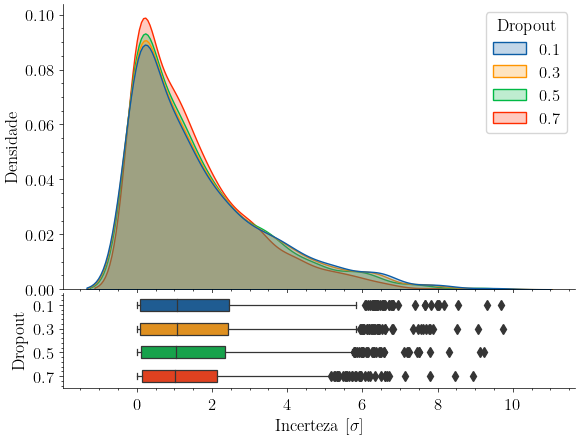

In [40]:
fig = plt.figure()
gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.02)

ax_kde = fig.add_subplot(gs[0])
ax_boxplot = fig.add_subplot(gs[1], sharex=ax_kde)

sns.kdeplot(data=dataframe[dataframe['Repetições']=='30'], x='entropy', hue='Dropout', fill=True, ax=ax_kde)
sns.boxplot(data=dataframe[dataframe['Repetições']=='30'], x='entropy', y='Dropout', width=0.5, ax=ax_boxplot, linewidth=0.9)

#ax_kde.set_title('Distribuição da Incerteza [$\sigma$]')
ax_kde.set_ylabel('Densidade')

ax_boxplot.set_xlabel('Incerteza [$\sigma$]')
plt.savefig(f'MCDP_dropout_p_{model}.pdf', 
                    dpi=300, 
                    bbox_inches='tight')

### Distribution of Reps

c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\

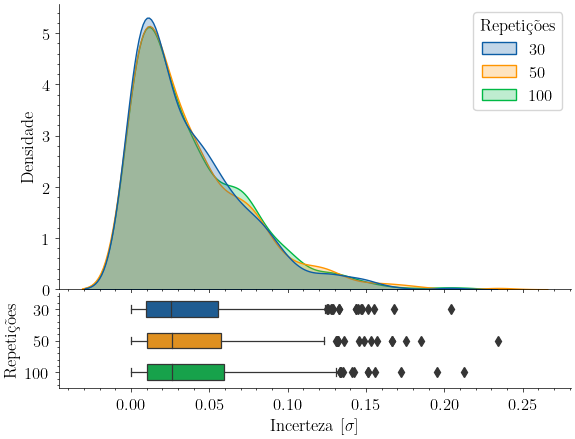

In [9]:
fig = plt.figure()

gs = fig.add_gridspec(2, 1,  height_ratios=(3, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.02)

ax_kde = fig.add_subplot(gs[0])
ax_boxplot = fig.add_subplot(gs[1], sharex=ax_kde)

sns.kdeplot(data=dataframe[dataframe['Dropout']=='0.5'], x='stds', hue='Repetições', fill=True, ax=ax_kde)
sns.boxplot(data=dataframe[dataframe['Dropout']=='0.5'], x='stds', y='Repetições', width=0.5, ax=ax_boxplot, linewidth=0.9)

#ax_kde.set_title('Uncertainty [$\sigma$] distribution over predictions')
ax_kde.set_ylabel('Densidade')

ax_boxplot.set_xlabel('Incerteza [$\sigma$]')
plt.savefig(f'MCDP_dropout_reps_{model}.pdf', 
                    dpi=300, 
                    bbox_inches='tight')

### Boxplot Reps and DropOut P

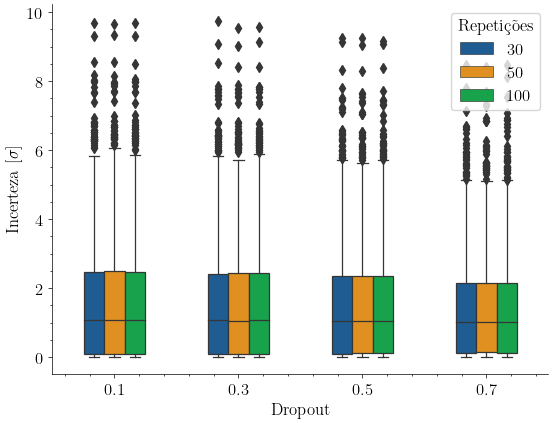

In [42]:
sns.boxplot(data=dataframe, y='entropy', hue='Repetições', x='Dropout', width=0.5, linewidth=0.9)
plt.ylabel('Incerteza [$\sigma$]')
plt.savefig(f'MCDP_p_reps_{model}.pdf', 
                    dpi=300, 
                    bbox_inches='tight')

### Corrects and Incorrects Uncertainty by Dropout P

<AxesSubplot:xlabel='Dropout', ylabel='entropy'>

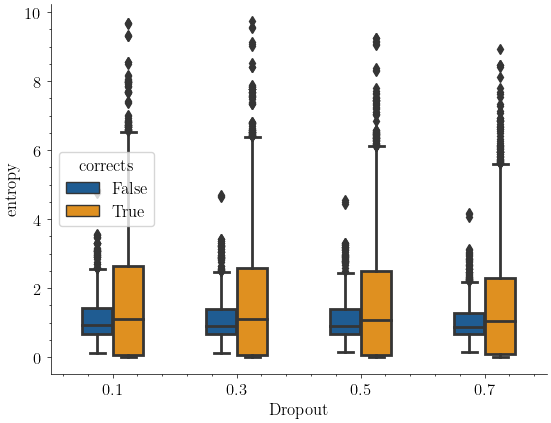

In [43]:
sns.boxplot(data=dataframe, y='entropy', hue='corrects', x='Dropout', width=0.5)

### Difference between correct and incorrect uncertainty

As the number of iterations did not influence the uncertainty, we used solely the dropout rate

In [44]:
mcdp_01_30 = dataframe[(dataframe['Dropout']=='0.1') & (dataframe['Repetições']=='30')]
mcdp_03_30 = dataframe[(dataframe['Dropout']=='0.3') & (dataframe['Repetições']=='30')]
mcdp_05_30 = dataframe[(dataframe['Dropout']=='0.5') & (dataframe['Repetições']=='30')]
mcdp_07_30 = dataframe[(dataframe['Dropout']=='0.7') & (dataframe['Repetições']=='30')]

for mcdp in [mcdp_01_30, mcdp_03_30, mcdp_05_30, mcdp_07_30]:
    print(abs(mcdp[mcdp['corrects']==True]['entropy'].mean() - mcdp[mcdp['corrects']==False]['entropy'].mean()))

0.5030926817519892
0.4905070565765306
0.4694586733484325
0.39889728646179057


### Measuring AUC difference

In [45]:
from sklearn.metrics import roc_auc_score
from calibration.metrics import ECE

In [46]:

drop_p = ['0.1', '0.3', '0.5', '0.7']
iterations = ['30', '50', '100']


probs = []
labels = []
auc_fold = []

dicty = {}

for y in iterations:
    for x in drop_p:
        filename = f'calib_results_MCDP_{x}_{y}.pkl'

        with open(os.path.join(path_experiments, filename), 'rb') as f:
            results = pickle.load(f)

        auc_fold = []
        
        for i, fold in enumerate(results.keys()):
            probs = results[fold]['probs']
            labels = results[fold]['labels']

            auc_fold.append(roc_auc_score(labels, probs))
            #auc_fold.append(ECE(probs, labels))

        auc_fold = np.array(auc_fold)

        dicty[f'{y}_{x}'] = {'auc_avg': auc_fold.mean(), 'auc_std': auc_fold.std()}



In [47]:
dicty

{'30_0.1': {'auc_avg': 0.9384868421052632, 'auc_std': 0.012680220352359729},
 '30_0.3': {'auc_avg': 0.9385964912280702, 'auc_std': 0.013143673276165552},
 '30_0.5': {'auc_avg': 0.9389254385964912, 'auc_std': 0.013502087296379427},
 '30_0.7': {'auc_avg': 0.9388157894736843, 'auc_std': 0.013460220719131452},
 '50_0.1': {'auc_avg': 0.9385233918128655, 'auc_std': 0.01324774391303165},
 '50_0.3': {'auc_avg': 0.938998538011696, 'auc_std': 0.01281477783324767},
 '50_0.5': {'auc_avg': 0.9384868421052632, 'auc_std': 0.013151852495061137},
 '50_0.7': {'auc_avg': 0.9404239766081872, 'auc_std': 0.012331938507913037},
 '100_0.1': {'auc_avg': 0.9384868421052632, 'auc_std': 0.012804975020039765},
 '100_0.3': {'auc_avg': 0.9388157894736843, 'auc_std': 0.012709842220036956},
 '100_0.5': {'auc_avg': 0.9391447368421053, 'auc_std': 0.012878003042571789},
 '100_0.7': {'auc_avg': 0.9399853801169591, 'auc_std': 0.012854693762941093}}

In [48]:
for test in dicty:
    print(f"{test} : {dicty[test]['auc_avg']:.4f}±{dicty[test]['auc_std']:.4f}")

30_0.1 : 0.9385±0.0127
30_0.3 : 0.9386±0.0131
30_0.5 : 0.9389±0.0135
30_0.7 : 0.9388±0.0135
50_0.1 : 0.9385±0.0132
50_0.3 : 0.9390±0.0128
50_0.5 : 0.9385±0.0132
50_0.7 : 0.9404±0.0123
100_0.1 : 0.9385±0.0128
100_0.3 : 0.9388±0.0127
100_0.5 : 0.9391±0.0129
100_0.7 : 0.9400±0.0129


# MCDP in lower dimension

In [152]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import torch
from torchvision import transforms

from models import *
from uncertainty.MCDropout import MCDropout

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pickle

In [153]:
model = VGGNB()

In [154]:
model.eval()
model.load_state_dict(torch.load('experiments\\UNIFESP+iCOPE\\VGGNB\\20241012_1628_VGGNB\\Model\\best_model.pt'))
model = model.to('cuda')


In [155]:
model_mcdp = MCDropout(model, p=0.5)


In [156]:
img_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=False),
    transforms.Normalize(
        mean=[0.36703529, 0.41083294, 0.50661294], std=[1, 1, 1])
])


In [157]:
image = cv2.imread('C:\\Users\\leonardo\\Desktop\\Mestrado\\Datasets\\Folds\\5\\Test\\ID1105_UNIFESP_S99_nopain.jpg')


In [158]:
embeddings_mcdp = []

def hook(model, input, output):
    output = output.detach().cpu().numpy()
    for x in output:
        embeddings_mcdp.append(x.flatten())

In [159]:
f_hook = model_mcdp.model.VGGFace.classifier[3].register_forward_hook(hook)     

In [160]:
with torch.no_grad():
    img = image / 255
    img = np.float32(img)
    img = transform(image).to('cuda')   

    img_batch = img.unsqueeze(0)

    probs_mcdp = model_mcdp.predict(img_batch, reps=100)

f_hook.remove()

In [161]:
np.array(embeddings_mcdp).shape

(100, 512)

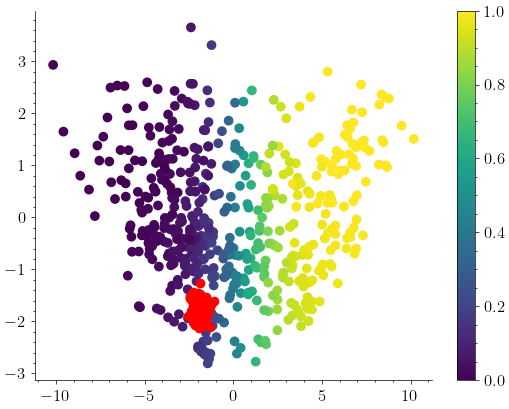

In [162]:
folder = 'UNIFESP+iCOPE'
model = 'VGGNB'
path_experiments = f'experiments\\{folder}\\{model}'

filename = 'results.pkl'

with open(os.path.join(path_experiments, filename), 'rb') as f:
    results = pickle.load(f)

probs = []
embeddings = []

for i, fold in enumerate(results.keys()):
  
    probs.extend(results[fold]['probs'])
    embeddings.extend(results[fold]['embeddings'])
   
scaler = MinMaxScaler()

embeddings_norm = scaler.fit_transform(embeddings)
embeddings_norm_mcdp = scaler.transform(embeddings_mcdp)

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_norm)
embeddings_pca_mcdp = pca.transform(embeddings_norm_mcdp)

plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1], c=probs)
plt.scatter(embeddings_pca_mcdp[:,0], embeddings_pca_mcdp[:,1], color='r')
plt.colorbar()

In [163]:
probs_mcdp = np.array(probs_mcdp.cpu())[0]

(0.0, 1.0)

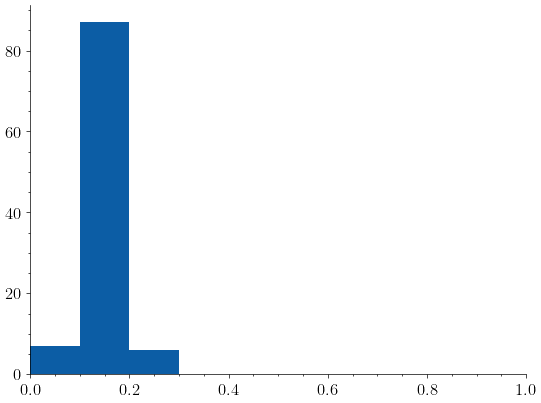

In [164]:
plt.hist(probs_mcdp, bins=10, range=[0,1])
plt.xlim([0,1])

In [165]:
probs_mcdp.mean()

0.14872907

In [166]:
probs_mcdp.std()

0.035419207

In [168]:
from sklearn.metrics import log_loss

log_loss(np.zeros(shape=probs_mcdp.shape), probs_mcdp, labels=[0,1])

0.1618983548033012